<a href="https://colab.research.google.com/github/JamaalDavis/AI-Product-Manager-Nanodegree-Program/blob/main/Topic_Modelling_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Topic Modelling For Business

---



#### Topic model is a statistical model to find latent "topics" or themes from a collection of documents (corpus).
#### It is a frequently used text-mining tool to extract hidden semantic structures in a corpus.
#### These structures could be considered as cluster words for a set of documents. This method is a type of 'unsupervised' machine learning as it does not require any predefined list of tags or training data for analysis.

#### Advantages:
    -The document-generative process can be adapted to other kinds of analyses, keeping only the analogy between document-topic-word and other kinds of objects. Therefore, the basis of topic modeling is the appointment of three objects: documents, words, and topics.
    -Manually doing the same is cumbersome and inefficient

#### Usage:

    Businesses can use Topic Modelling methods to decipher themes from annual reports, news covers, social media posts, related articles, latest trends in the domain, etc.

For this project we will use the articles on the emerging trend of:

### Digital Economy

The dataset hosts 2488 articles in this topic. The summary of each topic will be used as the base for the topic models.
 
 
  
   
This project is divided in 6 tasks:

####Task 1: Introduction to the dataset
####Task 2: Data cleaning and preparation
####Task 3: Exploratory analysis with WordCloud
####Task 4: Prepare data for Topic Modelling
####Task 5: Build Topic Model
####Task 6: Visualize Model

###Task 1: Introduction to the dataset

Importing Modules

In [ ]:
# Importing modules
import pandas as pd
import os
os.chdir('..')

import numpy as np
import re, nltk, spacy, gensim

import logging
import warnings
warnings.filterwarnings('ignore')  

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array

In [ ]:
# Upload .csv file
from google.colab import files 
uploaded = files.upload()

Saving DigitalEconomyDatasetTM (1).csv to DigitalEconomyDatasetTM (1).csv


In [ ]:
# Store dataset in a Pandas Dataframe
import io
df = pd.read_csv(io.BytesIO(uploaded['DigitalEconomyDatasetTM (1).csv']))

Read dataset

In [ ]:
df.head()

,Authors,Title,Year,Abstract,Keywords
0,"Nguyen Q.K., Dang Q.V.",Blockchain Technology - Opportunities for Emer...,2018,The recent major scientific conferences on the...,blockchain; digitaltechnology; distributed dia...
1,"Melnyk M., Korcelli-Olejniczak E., Chorna N., ...",Development of regional IT clusters in Ukraine...,2018,Introduction. Accelerated introduction of mode...,Country’s Innovation Ecosystem; Development of...
2,"Reisman R., Bertini M.",A novel architecture to monetize digital offer...,2018,As commerce continues to shift to the digital ...,Digital goods; Electronic commerce; Price disc...
3,"Bertola P., Teunissen J.",Fashion 4.0. Innovating fashion industry throu...,2018,Purpose: The on-going transition of societies ...,Design driven companies; Digital transformatio...
4,Moreno de la Santa J.G.-S.,The travel industry in 2018 – setting the scen...,2018,Purpose: The purpose of the paper is to identi...,China; Digital transformation; Global economy;...


In [ ]:
print(df.shape)

(2488, 5)


### Task 2: Data cleaning and preparation

Models will be built on the column 'Abstract'.
Other columns could be used for exploratory analysis.

In [ ]:
df['Abstract'].head(
  
)

0    The recent major scientific conferences on the...
1    Introduction. Accelerated introduction of mode...
2    As commerce continues to shift to the digital ...
3    Purpose: The on-going transition of societies ...
4    Purpose: The purpose of the paper is to identi...
Name: Abstract, dtype: object

In [ ]:
df.drop(df[df['Abstract'] == '[No abstract available]'].index, inplace = True)

In [ ]:
print(df.shape)

# Note the drop in number of rows

(2423, 5)


In [ ]:
import re

# Remove punctuation
df['p_abstract'] = df['Abstract'].map(lambda x: re.sub('[,\.!?]','',x))

# Convert the titles to lowercase
df['p_abstract'] =  df['p_abstract'].map(lambda x: x.lower())

# Print out the first rows of papers
df['p_abstract'] .head()

0    the recent major scientific conferences on the...
1    introduction accelerated introduction of moder...
2    as commerce continues to shift to the digital ...
3    purpose: the on-going transition of societies ...
4    purpose: the purpose of the paper is to identi...
Name: p_abstract, dtype: object

### Task 3: Exploratory Analysis with WordCloud

Build wordclouds for Title and Abstract fields.

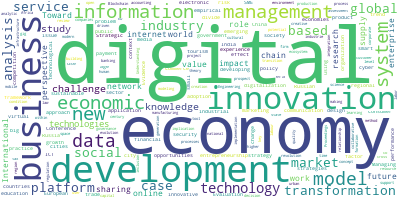

In [ ]:
#For Title

# Import the wordcloud library
from wordcloud import WordCloud

# Join the different titles together.
long_string = ','.join(list(df['Title'].values))

# Generate the word cloud
wordcloud = WordCloud(background_color="white",
                      max_words=500,
                      contour_width = 3,
                      contour_color = 'steelblue',
                      collocations = False).generate(long_string)

# Visualize the word cloud
wordcloud.to_image()


Exercise: Build a wordcloud with top 200 words using Abstract field.

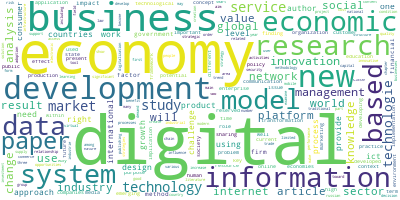

In [ ]:
#For Abstract
#Print only top 200 words

# Join the different processed abstracts together.
long_string = ','.join(list(df['p_abstract'].values))

# Generate the word cloud
wordcloud2 = WordCloud(background_color="white",
                      max_words=200,
                      contour_width = 3,
                      contour_color = 'steelblue',
                      collocations = False).generate(long_string)

# Visualize the word cloud
wordcloud2.to_image()


Remove the commonly used words (or irrelevant according to the context) from the wordcloud

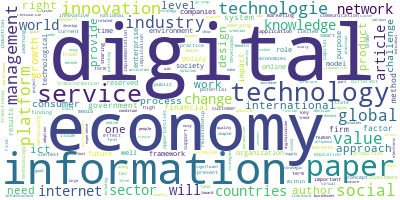

In [ ]:
## Remove STOPWORDS taking reference from previous wordcloud

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["research", "economic", "study", "data", "development", "result", "analysis", "model", 
                 "based", "using", "new", "market", "business", "system", "use"])

# Generate the word cloud
wordcloud3 = WordCloud(stopwords=stopwords,
                      background_color="white",
                      max_words=200,
                      contour_width = 3,
                      contour_color = 'steelblue',
                      collocations = False).generate(long_string)

# Visualize the word cloud
wordcloud3.to_image()

###Task 4: Prepare data for Topic Modelling

Step 1: Split sentences to words

In [ ]:
%%time
import gensim
from gensim.utils import simple_preprocess
def sent_to_words (sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
    data = df.p_abstract.values.tolist()
    data_words = list(sent_to_words(data))
    print(data_words[:1])


CPU times: user 21 µs, sys: 2 µs, total: 23 µs
Wall time: 37.2 µs


Step 2: Build N-grams

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count = 5, threshold= 100)                                                  # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold= 100)
# Faster way to get a sentence formatted as a bigram or trigram
bigram_mod =  gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

NameError: ignored

Step 3: Remove Stopwords

In [ ]:
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['research', 'study', 'data', 'development', 'result', 'analysis', 'model', 
                 'based', 'using', 'new', 'market', 'business', 'system', 'use'])
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return 
def make_bigrams(texts):
    return 
def make_trigrams(texts):
    return 

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Step 4: Lemmatize

In [ ]:
import spacy
# Remove Stop Words
data_words_nostops = 
# Form Bigrams
data_words_bigrams = 
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = 
# Lemmatize keeping only noun, adj, vb, adv
data_lemmatized = 
print

Step 5: Build Corpora

In [ ]:
import gensim.corpora as corpora
# Create Dictionary
id2word = 
# Create Corpus
texts = 
# Term Document Frequency
corpus = 
# View
print

###Task 5: Build topic model

In [ ]:
# Build LDA model
lda_model = 

In [ ]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
from gensim.models import CoherenceModel

# Compute Perplexity
print('\nPerplexity: ', )  # a measure of how good the model is. Lower value is preferred.

# Compute Coherence Score
coherence_model_lda = 
coherence_lda = 
print('\nCoherence Score: ', )

# Compute Coherence Score using UMass
coherence_model_lda = 
coherence_lda = 
print('\nCoherence Score u_mass: ', )

###Task 6: Visualize model

In [ ]:
# Visualize the topics
!pip install -U pyLDAvis
import pyLDAvis.gensim


In [ ]:
pyLDAvis.enable_notebook()
vis = 
vis

References

Liu, L., Tang, L., Dong, W., Yao, S., & Zhou, W. (2016). An overview of topic modeling and its current applications in bioinformatics. SpringerPlus, 5(1), 1608. https://doi.org/10.1186/s40064-016-3252-8)